# Analysis Rianne

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data\\sep2020.csv')

In [3]:
#Check if columns are dropped (currency, fx_rate, converted_usd_pledged)
df.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'deadline', 'goal',
       'id', 'launched_at', 'name', 'pledged', 'spotlight', 'state',
       'state_changed_at', 'usd_pledged', 'category_id', 'category_name',
       'category_parent_name', 'project_id'],
      dtype='object')

In [4]:
# Check different 'state' categories
df['state'].value_counts()

successful    128156
failed         76137
canceled        9138
live            6257
Name: state, dtype: int64

## Drop live records

In [5]:
# Drop records that are still live
df = df.loc[df['state'] != 'live']

# Check if records are dropped
df['state'].value_counts()

successful    128156
failed         76137
canceled        9138
Name: state, dtype: int64

## Drop double project ids

In [6]:
# Print number of records
print('number of records: ', len(df))

# sort by highest pledged and drop duplicated project ids
df = df.sort_values(by='usd_pledged',ascending=False).drop_duplicates(subset='project_id', keep='first')

# check number of records
print('number of records after dropping duplicated project ids: ', len(df))

number of records:  213431
number of records after dropping duplicated project ids:  188605


## Transforming dates

In [7]:
# Dates transformed [['created_at'], ['deadline'], ['launched_at'], ['state_changed_at']]
df[['created_at','deadline', 'launched_at', 'state_changed_at']].apply(pd.to_datetime, unit='s')

,created_at,deadline,launched_at,state_changed_at
26699,2020-02-10 01:53:24,2020-05-01 21:00:00,2020-03-31 15:03:58,2020-05-01 21:00:00
155651,2019-02-08 21:22:32,2019-04-19 06:59:00,2019-03-04 17:54:29,2019-04-19 06:59:00
99013,2012-05-15 01:20:03,2012-08-09 05:00:00,2012-07-10 12:44:41,2012-08-09 05:56:12
119358,2019-04-24 06:56:23,2019-06-06 14:00:38,2019-05-07 14:00:38,2019-06-06 14:00:38
201818,2020-02-08 02:08:24,2020-08-07 21:05:00,2020-07-07 15:00:01,2020-08-07 21:05:00
...,...,...,...,...
207257,2015-11-13 15:19:19,2016-01-12 16:59:05,2015-11-13 16:59:05,2016-01-12 16:59:05
151924,2015-11-14 03:51:42,2016-01-20 03:53:00,2015-11-21 21:07:20,2016-01-20 03:53:00
106147,2015-08-11 18:40:21,2015-08-14 16:40:44,2015-08-13 16:40:44,2015-08-14 16:40:44
9120,2017-09-19 21:25:20,2017-10-05 15:56:21,2017-09-20 15:56:21,2017-10-05 15:56:21


## Classify successful and unsuccessful

In [8]:
#Value_counts shows there are both canceled and failed campaigns. Categorize into successfull and unsuccessful
df['state_cat'] = np.where(df['state']=='successful', 'successful', 'unsuccessful')
df['state_cat'].value_counts()

successful      104210
unsuccessful     84395
Name: state_cat, dtype: int64

## Create avg pledge per backer

In [9]:
df['average_pledge'] = (df['usd_pledged']/df['backers_count'])

## Check for missing values

In [10]:
df.isna().sum()

backers_count               0
blurb                       8
country                     0
created_at                  0
deadline                    0
goal                        0
id                          0
launched_at                 0
name                        0
pledged                     0
spotlight                   0
state                       0
state_changed_at            0
usd_pledged                 0
category_id                 0
category_name               0
category_parent_name     7737
project_id                  0
state_cat                   0
average_pledge          16009
dtype: int64

In [11]:
df['category_parent_name'] = np.where(df['category_parent_name'].isnull(), df['category_name'], df['category_parent_name'])

## Hypothesis 2
**US vs NL** (Assumption: Silicon Valley vs. the Netherlands)
        -> Average pledged amount in NL hoger OF lager dan in US (1 of 2 sample T test)

In [12]:
# Create two samples: one US and one NL 
df_us = df.loc[df['country']=='US']
df_nl = df.loc[df['country']=='NL']
df_usnl = df[((df['country'] == 'US') | (df['country'] == 'NL'))]
print('Number of records US: ', len(df_us))
print('Number of records NL: ', len(df_nl))
print('Number of records Us & NL: ', len(df_usnl))

Number of records US:  131536
Number of records NL:  1660
Number of records Us & NL:  133196


In [13]:
df_nl['state'].value_counts()

failed        870
successful    685
canceled      105
Name: state, dtype: int64

In [14]:
#Import libraries

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2_contingency

#contingency table
contingency_table = pd.crosstab(df_usnl['state_cat'], df_usnl['country'])
contingency_table

country,NL,US
state_cat,,
successful,685,74722
unsuccessful,975,56814


In [15]:
#perform test
stats.chi2_contingency(contingency_table)

"""Because the p-value is smaller than 0.05, we can reject the 0 hypothesis. 
H0 = no statistical difference, that means there is a statistical difference. The chance to have a succesfull campaign in the US
is higher than in the Neterlands."""

'Because the p-value is smaller than 0.05, we can reject the 0 hypothesis. \nH0 = no statistical difference, that means there is a statistical difference. The chance to have a succesfull campaign in the US\nis higher than in the Neterlands.'

## Confidence interval amount pledged

In [16]:
# Sample represents the pledged US dollars for succesful campaigns within the “Tech” category
succesful_campaigns = df.loc[df['state'] == 'successful']
succesful_campaigns_tech = succesful_campaigns.loc[succesful_campaigns['category_parent_name'] == 'Technology']
sample = succesful_campaigns_tech['usd_pledged']

#Compute degrees of freedom
dfree = len(sample) -1

#Compute t-statistic, mean and standard error
t = stats.t.interval(0.95,dfree)[1]
x  = np.mean(sample)
se = np.std(sample) / np.sqrt(len(sample))

#Define confidence intervals
con_int = [round(num,3) for num in [x - (t * se) , x + (t * se)]]
print('With 95 % confidence, the average usd_pledged for a succesful campaign in Technology is between:', round(con_int[0]), 'and', round(con_int[1]), 'dollar')

With 95 % confidence, the average usd_pledged for a succesful campaign in Technology is between: 90172.0 and 102710.0 dollar


In [17]:
# Sample represents the numbers of backers for succesful campaigns within the “Tech” category
sample = succesful_campaigns_tech['goal']

#Compute degrees of freedom
dfree = len(sample) -1

#Compute t-statistic, mean and standard error
t = stats.t.interval(0.95,dfree)[1]
x  = np.mean(sample)
se = np.std(sample) / np.sqrt(len(sample))

#Define confidence intervals
con_int = [round(num,3) for num in [x - (t * se) , x + (t * se)]]
print('With 95 % confidence, the average goal for a succesful campaign in Technology is between:', round(con_int[0]), 'and', round(con_int[1]), 'dollar')

With 95 % confidence, the average goal for a succesful campaign in Technology is between: 31551.0 and 41940.0 dollar


## Goal differs significantly from pledged amout

In [18]:
#H0: mean goal = mean usd_pledged
#HA: mean goal != mean usd_pledged

from scipy.stats import ttest_rel
result = ttest_rel(succesful_campaigns_tech['usd_pledged'], succesful_campaigns_tech['goal'])
pvalue = result.pvalue
pvalue

if pvalue < 0.05:
    print('Reject null hypothesis: the mean of the goal and pledged amout significantly differ')
    
    if pvalue > 0.05:
        print('Confirm null hypothesis: the mean of the goal and pledged amout do not significantly differ')

Reject null hypothesis: the mean of the goal and pledged amout significantly differ


## In specific categories: Pledge amount asked - Pledged (goal - converted)  

In [24]:
# Create dataframe with succesful campaigns
df['difference'] = df['usd_pledged'] - df['goal']

In [26]:
# Create extra column with difference between goal and pledged amout
df_successful = df.loc[df['state_cat'] == 'successful']
df_successful.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'deadline', 'goal',
       'id', 'launched_at', 'name', 'pledged', 'spotlight', 'state',
       'state_changed_at', 'usd_pledged', 'category_id', 'category_name',
       'category_parent_name', 'project_id', 'state_cat', 'average_pledge',
       'difference'],
      dtype='object')

In [41]:
import matplotlib as plt 

In [43]:
plt.figure(figsize=(10,5))

TypeError: 'module' object is not callable

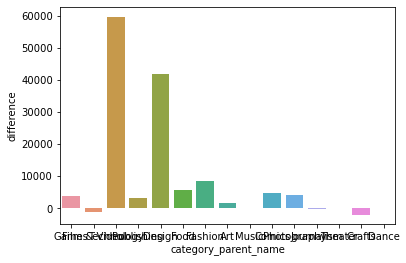

In [40]:
sns.barplot(x="category_parent_name", y="difference", data=df_successful, ci=None, (figsize=(10,5)      )